In [212]:
import requests
import json
import pandas as pd
import requests

from bs4 import BeautifulSoup
from zeep import Client
from otodom import category, utils

In [230]:
headers = {
    'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'
}


params = {
    "viewType": "listing",
    "limit": 72,
    "page": 1    
}

region = "pomorskie/gdansk/gdansk/gdansk"

r = requests.get(
    f"https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/{region}", 
    headers=headers,
    params=params,
)

print(r.url)

soup = BeautifulSoup(r.text, "lxml")

json_scripts = soup.find_all('script', {'type': 'application/ld+json'})

# Loop through each tag and load the JSON
for script in json_scripts:
    data = json.loads(script.string)

https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/pomorskie/gdansk/gdansk/gdansk?viewType=listing&limit=72&page=1


In [231]:
with open("data.json", "w+") as f:
    json.dump(data, f)

In [232]:
!open data.json

In [233]:
[d['@type'] for d in data['@graph']]

['WebPage', 'Product']

In [234]:
# there is just one product below
# indexing like that might cause an error in the future

In [235]:
offers = [d for d in data['@graph'] if d['@type'] == 'Product'][0]['offers']['offers']

In [236]:
df = pd.DataFrame(offers)

In [237]:
df.columns

Index(['@type', 'availability', 'image', 'price', 'priceCurrency', 'name',
       'url', 'itemOffered'],
      dtype='object')

In [238]:
df.iloc[0]['itemOffered']

{'@type': 'Accommodation',
 'description': 'Świetne 5 pokojowe mieszkanie na sprzedaż w miejscowości Gdańsk, Śródmieście, Stare Miasto, za cenę 1 559 000 zł. To mieszkanie na sprzedaż  na 2 piętrze ma 124,25 m² powierzchni użytkowej i 124,25 m² powierzchni całkowitej. Właściciel jako najważniejsze zalety mieszkania wymienia: balkon, piwnica, oddzielna kuchnia. Otodom 64226978',
 'address': {'@type': 'PostalAddress',
  'addressCountry': 'Polska',
  'addressLocality': 'Gdańsk',
  'addressRegion': 'pomorskie',
  'streetAddress': 'ul. Rybaki Górne'},
 'numberOfRooms': 5,
 'floorSize': {'@type': 'QuantitativeValue',
  'value': 124.25,
  'unitCode': 'MTK'}}

In [239]:
# TODO got to check if the @type: QuantitativeValue is defined for every floorSize the same way

In [240]:
def address_to_cords(address: dict) -> dict:
    return {}

In [241]:
def address_to_string(address: dict) -> str:
    return "{} {} {} {}".format(
        address["addressCountry"],
        address["addressLocality"],
        address["addressRegion"], 
        address["streetAddress"] if "streetAddress" in address else "",
    )

In [242]:
floor_sizes = []
numbers_of_rooms = []
addresses = []
cities = []
# regions = []
for i in range(len(df)):
    item = df['itemOffered'][i]
    floor_sizes.append(item['floorSize']['value'])
    numbers_of_rooms.append(item['numberOfRooms'])
    addresses.append(address_to_string(item['address']))
    cities.append(item['address']['addressLocality'])
    # regions.append(item['address']['addressRegion'])

In [243]:
df['floorSize'] = floor_sizes
df['address'] = addresses
df['numberOfRooms'] = numbers_of_rooms
df['city'] = cities
# df['region'] = region

In [244]:
# preprocess to only contain the relevant information
clean_df = df[['price', 'name', 'floorSize', 'address', 'numberOfRooms', 'city']]

In [245]:
import pickle

with open("df.pkl", "wb+") as f:
    pickle.dump(clean_df, f)

In [246]:
clean_df

,price,name,floorSize,address,numberOfRooms,city
0,1559000.0,"Gdańsk, Stare Miasto, Apartament, Rybaki Górne",124.25,Polska Gdańsk pomorskie ul. Rybaki Górne,5,Gdańsk
1,1130000.0,"2 pokoje w środku parku! Ogród, fitness, plaża",46.40,Polska Gdańsk pomorskie ul. Nadmorski Dwór,2,Gdańsk
2,670000.0,Mieszkanie 5 min do plaży,58.13,Polska Gdańsk pomorskie ul. Gdańska,3,Gdańsk
3,500000.0,2 pokoje we Wrzeszczu,37.00,Polska Gdańsk pomorskie ul. Romualda Traugutta,2,Gdańsk
4,807639.0,3-pokojowe mieszkanie 54m2 + balkon,54.60,Polska Gdańsk pomorskie ul. Stefana Jaracza,3,Gdańsk
...,...,...,...,...,...,...
58,1250000.0,3 pokojowy nowy apartament Nad Motławą z widokiem,50.00,Polska Gdańsk pomorskie ul. Toruńska,3,Gdańsk
59,556000.0,"Mieszkanie 45,77 Lawendowe Wzgórze",45.77,Polska Gdańsk pomorskie ul. Lawendowe Wzgórze,2,Gdańsk
60,780000.0,"Dwupoziomowe, 4 pokoje, 2 balkony, Osowa!",96.00,Polska Gdańsk pomorskie ul. Antygony,4,Gdańsk
61,750000.0,"Apartamentowiec 2 pokoje, Przymorze",39.50,Polska Gdańsk pomorskie,2,Gdańsk


In [252]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [260]:
X = df[['floorSize', 'numberOfRooms']]

# Target variable
y = df['price']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Generate predictions and plot regression line
x_range = np.linspace(X.min(), X.max(), 100)
y_pred_line = model.predict(x_range)

# Step 4: Model Evaluation
y_pred = model.predict(X_test)
print(f"Root Mean Squared Error: {mean_squared_error(y_test, y_pred, squared=False)}")

Root Mean Squared Error: 505185.87157111114


/Users/piotrostr/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [249]:
!pip install -q matplotlib

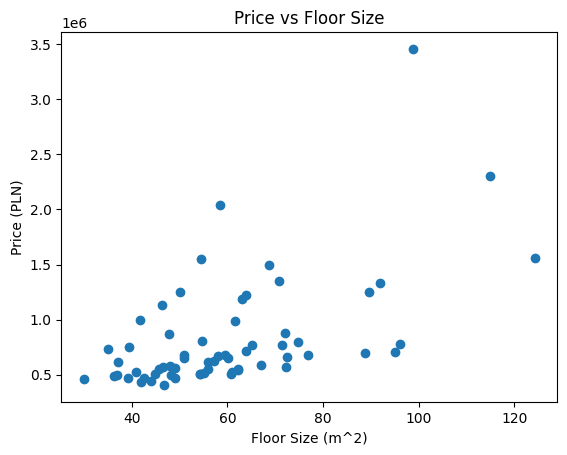

In [266]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have already created the 'city' column in your dataframe
# df['city'] = ...

# Scatter plot
fig, ax = plt.subplots()
ax.scatter(clean_df['floorSize'], clean_df['price'])
ax.set_xlabel('Floor Size (m^2)')
ax.set_ylabel('Price (PLN)')
ax.set_title('Price vs Floor Size')

plt.show()

In [267]:
df['price_per_m2'] = df['price'] / df['floorSize']

In [269]:
df.sort_values(by="price_per_m2")[df['price'] <= 500_000]

/var/folders/t_/c87kvtx965d_dmwgdt0bzdrm010cps/T/ipykernel_26447/1382230013.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values(by="price_per_m2")[df['price'] <= 500_000]


,@type,availability,image,price,priceCurrency,name,url,itemOffered,floorSize,address,numberOfRooms,city,price_per_m2
51,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,407000.0,PLN,2-pokojowe mieszkanie 46m2 + ogródek Bez Prowizji,https://www.otodom.pl/pl/oferta/2-pokojowe-mie...,"{'@type': 'Accommodation', 'description': 'Świ...",46.72,Polska Gdańsk pomorskie ul. Starogardzka,2,Gdańsk,8711.472603
9,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,469000.0,PLN,Nova Stężycka - kameralna inwestycja na Jasieniu!,https://www.otodom.pl/pl/oferta/nova-stezycka-...,"{'@type': 'Accommodation', 'description': 'Świ...",49.00,Polska Gdańsk pomorskie ul. Stężycka,3,Gdańsk,9571.428571
31,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,441800.0,PLN,Powrót do SPRZEDAŻY _ Nowe 2 pokoje +OGRÓD PRE...,https://www.otodom.pl/pl/oferta/powrot-do-sprz...,"{'@type': 'Accommodation', 'description': 'Świ...",44.13,Polska Gdańsk pomorskie,3,Gdańsk,10011.330161
52,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,497000.0,PLN,2 pokoje z osobną kuchnią od południa,https://www.otodom.pl/pl/oferta/2-pokoje-z-oso...,"{'@type': 'Accommodation', 'description': 'Świ...",48.20,Polska Gdańsk pomorskie ul. Leszczyńskich,2,Gdańsk,10311.203320
32,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,432800.0,PLN,Gotowe 2 pokoje _ Ostatnie sztuki -> 26.08 ZOBACZ,https://www.otodom.pl/pl/oferta/gotowe-2-pokoj...,"{'@type': 'Accommodation', 'description': 'Świ...",41.93,Polska Gdańsk pomorskie,2,Gdańsk,10321.965180
33,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,465551.0,PLN,2-pokojowe mieszkanie 42m2 + ogródek,https://www.otodom.pl/pl/oferta/2-pokojowe-mie...,"{'@type': 'Accommodation', 'description': 'Świ...",42.59,Polska Gdańsk pomorskie prof. Jerzego Stankiew...,2,Gdańsk,10930.993191
53,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,467000.0,PLN,Słoneczne mieszkanie taras Gdańsk Lotnisko Ikea,https://www.otodom.pl/pl/oferta/sloneczne-mies...,"{'@type': 'Accommodation', 'description': 'Świ...",39.18,Polska Gdańsk pomorskie ul. Podchorążych,2,Gdańsk,11919.346605
49,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,487159.0,PLN,1-pokojowe mieszkanie 36m2 + ogródek Bezpośrednio,https://www.otodom.pl/pl/oferta/1-pokojowe-mie...,"{'@type': 'Accommodation', 'description': 'Świ...",36.38,Polska Gdańsk pomorskie Starowiejska/ul. Sucha,1,Gdańsk,13390.846619
3,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,500000.0,PLN,2 pokoje we Wrzeszczu,https://www.otodom.pl/pl/oferta/2-pokoje-we-wr...,"{'@type': 'Accommodation', 'description': 'Świ...",37.00,Polska Gdańsk pomorskie ul. Romualda Traugutta,2,Gdańsk,13513.513514
15,Offer,InStock,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,459000.0,PLN,Przymorze dwa pokoje blisko morza z balkonem,https://www.otodom.pl/pl/oferta/przymorze-dwa-...,"{'@type': 'Accommodation', 'description': 'Świ...",30.00,Polska Gdańsk pomorskie ul. Obrońców Wybrzeża,2,Gdańsk,15300.000000
